In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from d2l import torch as d2l
import numpy as np
from utils.PSGD import *

d2l.init_Seed()
device = d2l.get_device()

No GPU!


In [2]:
def synthetic_data(w, b, m_examples, scale=1):
    X = torch.randn((m_examples, len(w)))
    X[:, 1] *= scale
    y = torch.mv(X, w)
    y += torch.normal(0, 0.5, y.shape)
    return X, y

def initial(config, w=None, b=0.0, scale=1):
    m, n = config["m"], config['n']
    return synthetic_data(w, b, m, scale)

def formal_sol(X, y):
    # X_b = torch.cat([torch.ones((len(X), 1)), X], 1)
    X_b = X
    formal_sol = torch.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    global_minima = squared_loss(linreg(X, formal_sol), y)
    return formal_sol, global_minima

# Config the set

In [3]:
config = {
    "m": 200,
    "n": 2,
    "batch_size": 200,
    "lr": 0.15,
    "n_epochs": 60,
    "optimizer": "SGD",
    # "optimizer": "Adam",
    # "optimizer": "Adagrad",
    # "optimizer": "Adadelta",
    "optim_hparas": {
        'lr': 0.015,         # for SGD and Adam
#         'momentum': 0.9,
#         'nesterov':True
    }
}

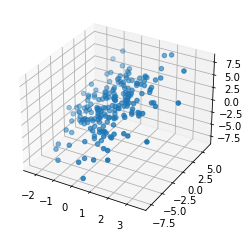

In [4]:
true_w = torch.tensor([1., 1.])
X, y = initial(config, true_w, scale=2.5)
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), y.numpy())
plt.show()

# from scratch

In [5]:
def data_iter(X, y, batch_size=10):
    m = len(X)
    indices = torch.randperm(m)
    for i in range(0, m, batch_size):
        batch_indices = indices[i:min(i + batch_size, m)]
        yield X[batch_indices], y[batch_indices]

def linreg(X, w):
    return X @ w

def squared_loss(y_hat, y):
    return ((y_hat - y) ** 2).mean(dim=0)

In [6]:
(w1_minima, w2_minima), minima = formal_sol(X, y)
(w1_minima, w2_minima), minima

((tensor(1.0194), tensor(0.9918)), tensor(0.2625))

# Consice

In [7]:
def prep_dataloader(X, y, mode, batch_size):
    dataset = data.TensorDataset(X, y)
    return data.DataLoader(dataset, batch_size, shuffle=(mode == 'train'))

In [8]:
tr_set = prep_dataloader(X, y, 'train', config['batch_size'])

In [9]:
class Linreg(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        self.net = nn.Sequential(nn.Linear(n_features, 1))
        
        # self.net[0].weight.data.normal_(0, 0.01)
        self.net[0].weight.data.fill_(-1.5)

        # self.net[0].bias.data.fill_(torch.rand(1,).item())
        self.net[0].bias.data.fill_(0)


    def forward(self, X):
        return self.net(X).squeeze(1)


In [10]:
def train(model, tr_set, te_set, loss, optimizer, scheduler=None, device='cpu', n_epochs=10, early_stop=5):

    epoch = 0

    loss_record = {"train": [], "dev": []}
    trace = [model.net[0].weight.data.cpu().numpy().copy()[0]]

#     animator = d2l.Animator(xlabel='epoch', xlim=[1, n_epochs], ylim=[0.2, 1.5], 
#                             legend=['train loss', 'test loss'])

    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            if issubclass(optimizer.__class__, BasePSSGD):
                optimizer.select_candicate()
            l = loss(model(X), y)
            l.backward()
            if issubclass(optimizer.__class__, BasePSSGD):
                optimizer.setloss(l.detach().cpu().item())
            
            optimizer.step()
            loss_record['train'].append(l.detach().cpu().item())
            trace.append(model.net[0].weight.data.cpu().numpy().copy()[0])

        epoch += 1
        
        train_l = dev(model, te_set, loss, device)
#         animator.add(epoch, (train_l, ))
        # print(f"epoch: {epoch:3d}, loss: {train_l: .4f}")
    
    return trace

In [11]:
def dev(model, dv_set, loss, device='cpu'):
    model.eval()
    total_loss = 0

    for X, y in dv_set:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            total_loss += loss(model(X), y).cpu().item() * len(y)
    total_loss /= len(dv_set.dataset)
    
    return total_loss

In [12]:
def visualization(trace, loss):
    fig = plt.figure(figsize=(12, 6))

    gs = GridSpec(2, 2, width_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[:, 1], projection='3d')
    ax2 = fig.add_subplot(gs[:, 0])
    # ax3 = fig.add_subplot(gs[1, 0])

    def loss_wrt_wgts(w1, w2):
        w = torch.Tensor([w1, w2])
        y_hat = X @ w
        return loss(y_hat, y)
    
    loss_wgts = np.vectorize(loss_wrt_wgts)
    x1, x2 = torch.meshgrid(torch.linspace(true_w[0].item() - 2.6, true_w[0].item() + 2.6, 30),
                        torch.linspace(true_w[1].item() - 2.6, true_w[1].item() + 2.6, 30))
    z = loss_wgts(x1, x2)

    # x1, x2 = torch.meshgrid(torch.linspace(true_w[0].item() - 2.6, true_w[0].item() + 2.6, 30),
    #                     torch.linspace(true_w[1].item() - 2.6, true_w[1].item() + 2.6, 30))

    # x = torch.cat([x1.reshape(-1, 1), x2.reshape(-1, 1)], dim=1)
    # z = squared_loss(linreg(X, x.T), y.reshape(-1, 1)).reshape(30, -1)

    ax1.plot_surface(x1, x2, z, cmap='viridis', alpha=0.7)
    ax1.scatter(w1_minima.item(), w2_minima.item(), minima, c='red', s=100, marker='x')
    ax1.plot3D(*zip(*trace), [squared_loss(linreg(X, w), y) for w in trace], c='r', marker='o')

    ax1.set_title('Loss Surface', fontsize=16)
    ax1.set_xlabel('w1') 
    ax1.set_ylabel('w2')
    ax1.set_zlabel('Loss')
    ax1.view_init(40, 10)


    ax2.contour(x1, x2, z, 20, colors='#1f77b4')
    ax2.plot(*zip(*trace), '-o', color='#ff7f0e')
    ax2.scatter(w1_minima.item(), w2_minima.item(), marker='x', s=100, color='r', label="global minima")
    # ax2.axes.get_xaxis().set_visible(False)
    # ax2.axes.get_yaxis().set_visible(False)
    ax2.set_title('Loss Contour', fontsize=16)
    ax2.set_xlabel('w1') 
    ax2.set_ylabel('w2')
    ax2.legend()
    ax2.axis('equal')

    plt.show()

# TEST

In [13]:
model = Linreg(config["n"]).to(device)
loss = nn.MSELoss(reduction='mean')
optimizer = getattr(torch.optim, config['optimizer'])(
    [model.net[0].weight], **config['optim_hparas'])
ggg = PSSGDv4(optimizer)
trace = train(model, tr_set, tr_set, loss, ggg, device=device, n_epochs=config['n_epochs'])

[51.189212799072266, 51.189212799072266, 51.189212799072266, 51.1892204284668, 51.189212799072266, 51.189212799072266]
[51.189212799072266, 51.189212799072266, 51.189212799072266, 51.1892204284668, 51.189212799072266, 51.189212799072266]
[51.189212799072266, 51.189212799072266, 51.189212799072266, 51.1892204284668, 51.189212799072266, 51.189212799072266]
[51.189212799072266, 51.189212799072266, 51.189212799072266, 51.1892204284668, 51.189212799072266, 51.189212799072266]
[51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266]
[51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266]
[51.1892204284668, 51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266]
[51.1892204284668, 51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266, 51.189212799072266]
[51.189212799072266, 51.189212799072266, 51.

In [14]:
model.net[0].weight.data

tensor([[-1.3909, -0.9971]])

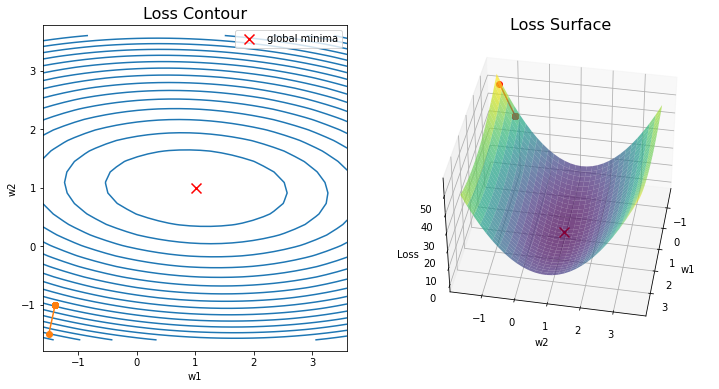

In [15]:
visualization(trace, loss)